In [1]:
from torchvision.models.segmentation import deeplabv3
import torch.nn as nn
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from utils import data
import pandas as pd
from torch.utils.data import Subset, DataLoader
from torchvision import transforms
import config
from tqdm import tqdm
import kornia
import matplotlib.pyplot as plt
import numpy as np


In [2]:
#Should be cuda:0 in colab and cpu in local.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
DATA_PATH = config.PATH_TO_DATA

train_test_split = pd.read_csv("dataset/data_split.csv")
train_split = train_test_split[train_test_split['split'] == "Train"]['sampleid'].values
test_split = train_test_split[train_test_split['split'] == "Test"]['sampleid'].values

In [4]:
preprocess = transforms.Compose([
    transforms.Resize((256,256)), # Optional: Resize the input PIL Image to the given size.
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
preprocess_mask = transforms.Compose([
    kornia.geometry.Resize((256,256), interpolation='nearest'), # Optional: Resize the input PIL Image to the given size.
])
dataset = data.PlanetDataset(data_dir=DATA_PATH,bands=[0,1,2],transform=preprocess,target_transform=preprocess_mask)

In [5]:
print((dataset.id2index))

training_set = Subset(dataset=dataset,indices = [dataset.id2index[image_id] for image_id in train_split])
test_set = Subset(dataset=dataset,indices = [dataset.id2index[image_id] for image_id in test_split])

{11468: 0, 10684: 1, 22511: 2, 10504: 3, 10174: 4, 21903: 5, 21830: 6, 20999: 7, 10786: 8, 11423: 9, 11450: 10, 20860: 11, 11656: 12, 10765: 13, 11730: 14, 21695: 15, 10167: 16, 21343: 17, 10410: 18, 10917: 19, 10299: 20, 11543: 21, 21832: 22, 10455: 23, 21986: 24, 20490: 25, 11103: 26, 21694: 27, 10298: 28, 11624: 29, 11281: 30, 11506: 31, 20858: 32, 10417: 33, 20476: 34, 20460: 35, 11140: 36, 10588: 37, 20670: 38, 20846: 39, 10868: 40, 21317: 41, 21624: 42, 20733: 43, 10328: 44, 10795: 45, 21016: 46, 10056: 47, 10038: 48, 11111: 49, 11761: 50, 10429: 51, 10005: 52, 11304: 53, 11034: 54, 20501: 55, 20880: 56, 10711: 57, 11298: 58, 21837: 59, 10209: 60, 21320: 61, 10548: 62, 22416: 63, 10478: 64, 10443: 65, 10486: 66, 21243: 67, 10451: 68, 11152: 69, 20410: 70, 10930: 71, 11341: 72, 11337: 73, 10458: 74, 11780: 75, 21628: 76, 20958: 77, 11024: 78, 11224: 79, 21656: 80, 10538: 81, 10454: 82, 21864: 83, 10880: 84, 10208: 85, 11094: 86, 11698: 87, 20426: 88, 10528: 89, 11322: 90, 10731: 9

In [6]:
print(f"The training split has {len(training_set)} samples ({len(training_set)/len(dataset):.2%} of the full dataset).")

The training split has 1030 samples (63.90% of the full dataset).


In [7]:
from pprint import pprint
training_set[0][1].shape

/home/jprado/anaconda3/envs/ipeo_project/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([256, 256])

In [8]:

def prepare_model(backbone_model="mbv3", num_classes=2):
    """Source : https://learnopencv.com/deep-learning-based-document-segmentation-using-semantic-segmentation-deeplabv3-on-custom-dataset/"""
    weights = 'DEFAULT'    # Initialize model with pre-trained weights.
    if backbone_model == "mbv3":
        model = deeplabv3.deeplabv3_mobilenet_v3_large(weights=weights)
    elif backbone_model == "r50":
        model = deeplabv3.deeplabv3_resnet50(weights=weights)
    elif backbone_model == "r101":
        model = deeplabv3.deeplabv3_resnet101(weights=weights)
    else:
        raise ValueError("Wrong backbone model passed. Must be one of 'mbv3', 'r50' and 'r101' ")
 
    model.classifier[4]         = nn.LazyConv2d(num_classes, 1)
    model.aux_classifier[4] = nn.LazyConv2d(num_classes, 1)
 
    return model

model = prepare_model(num_classes = 2)

def weighted_focal_loss(p,y_true,alpha=0.7,gamma=1):
    """Weighted Focal Loss as described in https://www.mdpi.com/2072-4292/14/19/4694#B26-remotesensing-14-04694"""
    p = p['out'].softmax(dim=1)[:,0,:,:] #transform model output to probabilities. Following the paper, we consider only the probability of the POSITIVE class
    loss =  torch.mean(y_true*(-alpha*(torch.ones(size=p.size())-p)**gamma*torch.log(p)) - (torch.ones(size=p.size())-y_true)*(1-alpha)*(p)**gamma*torch.log(p))
    return loss

/home/jprado/anaconda3/envs/ipeo_project/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [9]:
max_epochs = 1
params = {'batch_size': 4,
          'shuffle': True}
learning_rate = 0.001 
optimizer = optim.Adam(model.parameters(),lr=learning_rate)
dataloader = DataLoader(training_set, **params)
criterion = weighted_focal_loss
# Loop over epochs
loss_list = [0]
scheduler = CosineAnnealingLR(optimizer, T_max=len(dataloader) * max_epochs)
for epoch in range(max_epochs):
    # Training
    loss=0
    progress_bar = tqdm(total=len(dataloader), desc=f'Loss: {loss:.5f}')

    for local_batch, local_labels in dataloader:
        # Transfer to GPU
        local_batch, local_labels = local_batch.to(device), local_labels.to(device)
        outputs = model(local_batch)
        loss = criterion(outputs, local_labels)  # Calculate the loss
        loss_list.append(loss.item())
        # Backward pass and optimization
        optimizer.zero_grad()  # Clear gradients
        loss.backward()  # Compute gradients
        optimizer.step()  # Update weights
        scheduler.step()  # Update learning rate
        progress_bar.set_description(f'Loss: {loss.item():.5f}')
        progress_bar.update(1)  # Manually update the progress bar


Loss: 0.00069: 100%|██████████| 258/258 [04:14<00:00,  1.20it/s]

Text(0, 0.5, 'Loss')

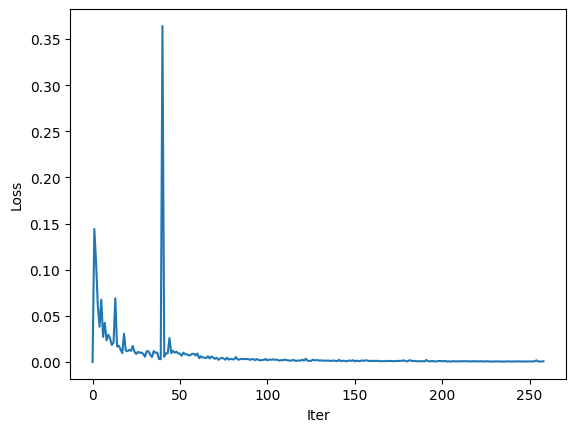

In [10]:
fig,ax=plt.subplots()
ax.plot(loss_list)
ax.set_xlabel("Iter")
ax.set_ylabel("Loss")

In [11]:
import torch
from sklearn.metrics import precision_score, recall_score, f1_score

test_dataloader = DataLoader(test_set, **params)
#tqdm.close()

# Assuming you have a trained model, test data, and labels
model.eval()  # Set the model to evaluation mode
y_true = []  # True labels
y_pred = []  # Predicted labels

with torch.no_grad():
    for local_batch, local_labels in tqdm(test_dataloader):
        local_batch, local_labels = local_batch.to(device), local_labels.to(device)
        outputs = model(local_batch)['out']
        _, predicted = torch.max(outputs, 1)
        
        y_true.extend(local_labels.cpu().numpy())  # Collect true labels
        y_pred.extend(predicted.cpu().numpy())  # Collect predicted labels

# Calculate precision, recall, and F1 score
y_pred = np.array(y_pred).flatten()
y_true = np.array(y_true).flatten()
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

/home/jprado/anaconda3/envs/ipeo_project/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 71/71 [00:11<00:00,  6.40it/s]


Precision: 0.38
Recall: 0.58
F1 Score: 0.46
